In [1]:
# Run 'source ~/.profile'
import satpy
from satpy import Scene
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from global_land_mask import globe

sys.path.insert(0,'/home/cameron/Projects/')

In [2]:
points_file = '/home/cameron/Dokumenter/Data/frohavet/frohavet_2023-03-29_1044Z-bin3.points'
nc_file = '/home/cameron/Dokumenter/Data/frohavet/frohavet_2023-03-29_1044Z-l1a.nc'
l1a_prefix = nc_file.rsplit('-', maxsplit=1)[0]
l1a_file_prefix = l1a_prefix.split('/')[-1]

files = [points_file, nc_file] # List of files to be read by SatPy

# Create SatPy scene
scene = Scene(filenames=files, reader='hypso1_l1a_nc', reader_kwargs={'flip': True})


In [4]:
scene['band_0']

<xarray.DataArray (y: 956, x: 684)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    crs      object +proj=longlat +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes:
    start_time:           2023-03-29 10:44:00
    capture_config:       {'aoi_x': 428, 'aoi_y': 266, 'background_value': 72...
    end_time:             2023-03-29 10:44:00
    reader:               hypso1_l1a_nc
    area:                 Shape: (956, 684)\nLons: <xarray.DataArray (y: 956,...
    name:                 band_0
    wavelength:           388
    modifiers:            ()
    _satpy_id:            DataID(name='band_0', wavelength=388, modifiers=())
    ancillary_variables:  []

In [52]:
datasets = scene.available_dataset_names()
scene.load(datasets)
ds = scene.to_xarray()



import re

band_names = scene.all_dataset_names()

# Remove latitude and longitude
band_names.remove('latitude')
band_names.remove('longitude')

# Extract numbers and sort
sorted_band_names = sorted(band_names, key=lambda x: int(re.search(r'\d+', x).group()))


ds = ds[sorted_band_names]

#da = ds.to_stacked_array('band', sample_dims=['y','x'])
#da.drop_vars(['latitude', 'longitude'])
#da.to_numpy().shape
da = ds.to_stacked_array('band', sample_dims=['y','x'])


In [53]:
da

<xarray.DataArray 'band_0' (y: 956, x: 684, band: 120)>
array([[[  0.       ,   0.       ,   0.       , ...,  56.475536 ,
          59.266304 ,  60.57138  ],
        [  0.       ,   0.       ,   0.       , ...,  56.652164 ,
          59.29657  ,  61.054504 ],
        [  0.       ,   0.       ,   0.       , ...,  55.37321  ,
          58.399166 ,  60.239872 ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,   7.6933765,
           8.276118 ,   9.8070545],
        [  0.       ,   0.       ,   0.       , ...,   7.4140706,
           8.6399   ,   9.760468 ],
        [  0.       ,   0.       ,   0.       , ...,   7.76107  ,
           8.874554 ,  10.112703 ]],

       [[  0.       ,   0.       ,   0.       , ...,  58.778618 ,
          60.587463 ,  62.60668  ],
        [  0.       ,   0.       ,   0.       , ...,  58.278446 ,
          61.164177 ,  62.88745  ],
        [  0.       ,   0.       ,   0.       , ...,  56.87472  ,
          59.4435   ,  61.773407 ],
...
        [  0.       ,   0.       ,   0.       , ...,  51.89013  ,
          53.913517 ,  55.754227 ],
        [  0.       ,   0.       ,   0.       , ...,  53.506367 ,
          56.51554  ,  57.443054 ],
        [  0.       ,   0.       ,   0.       , ...,  55.979156 ,
          58.39675  ,  60.244698 ]],

       [[  0.       ,   0.       ,   0.       , ..., 173.93263  ,
         178.21178  , 181.73535  ],
        [  0.       ,   0.       ,   0.       , ..., 177.67618  ,
         182.21916  , 187.63676  ],
        [  0.       ,   0.       ,   0.       , ..., 177.6853   ,
         181.83946  , 187.82571  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  39.76994  ,
          42.001755 ,  44.206608 ],
        [  0.       ,   0.       ,   0.       , ...,  42.412056 ,
          44.861725 ,  46.32023  ],
        [  0.       ,   0.       ,   0.       , ...,  45.110107 ,
          47.13009  ,  49.512848 ]]], dtype=float32)
Coordinates:
  * band      (band) object MultiIndex
  * variable  (band) object 'band_0' 'band_1' 'band_2' ... 'band_118' 'band_119'
Dimensions without coordinates: y, x
Attributes:
    capture_config:  {"aoi_x": 428, "aoi_y": 266, "background_value": 72, "bi...
    end_time:        2023-03-29 10:44:00
    long_name:       band_0
    modifiers:       []
    reader:          hypso1_l1a_nc
    start_time:      2023-03-29 10:44:00
    wavelength:      388

In [48]:
type(ds)

xarray.core.dataset.Dataset

<xarray.Dataset>
Dimensions:   (y: 956, x: 684)
Dimensions without coordinates: y, x
Data variables: (12/120)
    band_0    (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    band_1    (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    band_2    (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    band_3    (y, x) float32 42.46 42.52 41.54 40.26 40.63 ... 0.0 0.0 0.0 0.0
    band_4    (y, x) float32 70.98 78.8 82.33 78.3 ... 57.53 58.32 58.78 58.52
    band_5    (y, x) float32 71.96 82.11 83.16 82.1 ... 58.3 59.56 58.84 60.32
    ...        ...
    band_114  (y, x) float32 55.63 54.56 54.1 53.34 ... 35.45 38.58 41.31 44.72
    band_115  (y, x) float32 55.74 55.22 53.19 53.14 ... 36.0 38.65 41.56 44.89
    band_116  (y, x) float32 55.33 54.97 54.78 54.24 ... 35.86 39.23 41.68 44.55
    band_117  (y, x) float32 56.48 56.65 55.37 55.32 ... 36.94 39.77 42.41 45.11
    band_118  (y, x) float32 59.27 59.3 58.4 57.02 ... 38.63 42.0 44.86 47.13
    band_119  (y, x) float32 60.57 61.05 60.24 59.79 ... 41.57 44.21 46.32 49.51
Attributes:
    history:      Created by pytroll/satpy on 2024-03-26 17:55:02.078323
    Conventions:  CF-1.7

In [3]:
# Compute wl and choose bands for band ratio
spectral_coeffs = [ -5.719788129534360902e-09,
                    1.324037080791479811e-05, 
                    3.751455956374321055e-01,
                    2.264762366937773663e+02]
x_start = 428
x_stop = 1508
image_width = 120

x = np.linspace(x_start, x_stop, image_width)

h1_wl = spectral_coeffs[3] + spectral_coeffs[2]*x + spectral_coeffs[1]*x*x + spectral_coeffs[0]*x*x*x


a = abs(h1_wl-549)
min_index = np.argmin(a)
band_549nm_name = 'band_' + str(min_index)

a = abs(h1_wl-663)
min_index = np.argmin(a)
band_663nm_name = 'band_' + str(min_index)

scene.load(['latitude', 'longitude', band_549nm_name, band_663nm_name])
#datasets = scene.available_dataset_names()
#scene.load(datasets)

print(band_549nm_name)
print(scene['band_46'].wavelength) # This does not match?

print(band_663nm_name)
print(scene['band_78'].wavelength) # This does not match?

band_46
550
band_78
662


In [4]:
# Get image dimensions
img_dims = scene['latitude'].shape

# Land mask
land_mask = np.zeros(img_dims, dtype=bool)

lats = scene['latitude'].data
lons = scene['longitude'].data

for x in range(0,img_dims[0]):
    for y in range(0,img_dims[1]):
        lat = lats[x][y]
        lon = lons[x][y]
        land_mask[x][y] = globe.is_land(lat, lon)

# Cloud mask
cloud_mask = np.zeros(img_dims, dtype=bool)

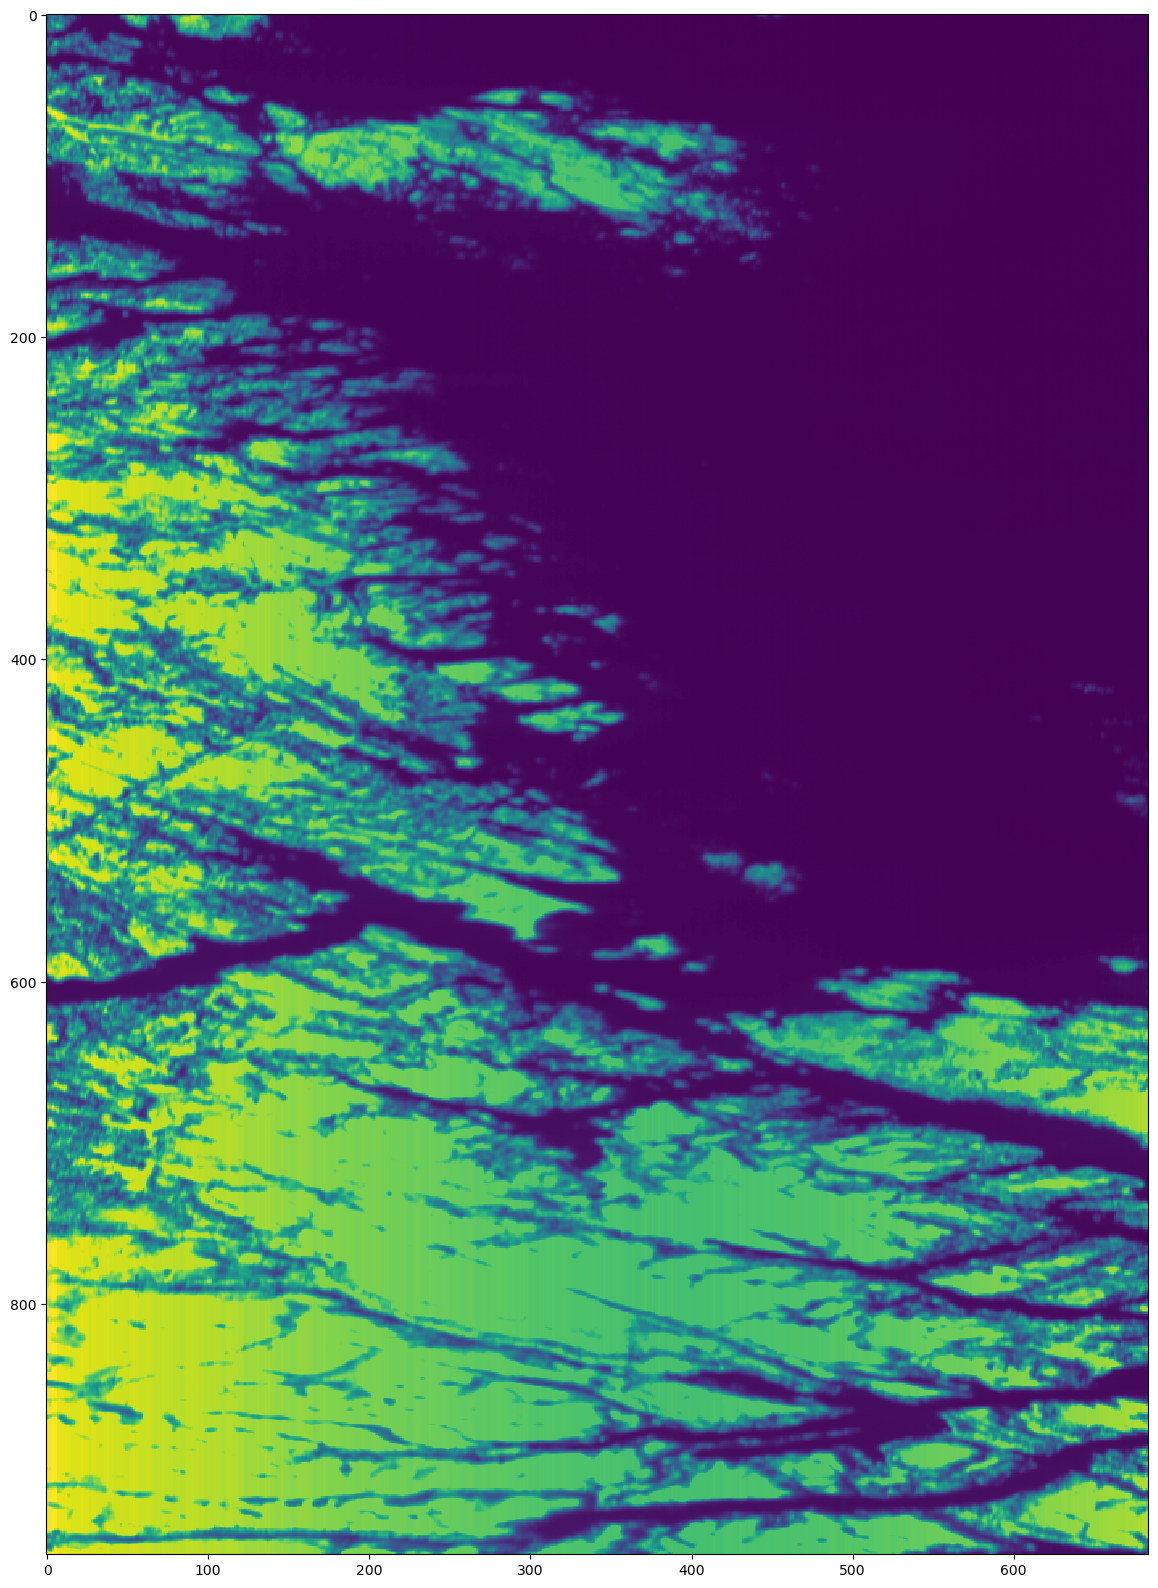

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(scene[band_549nm_name], interpolation='none')
#scene.show(band_549nm_name)

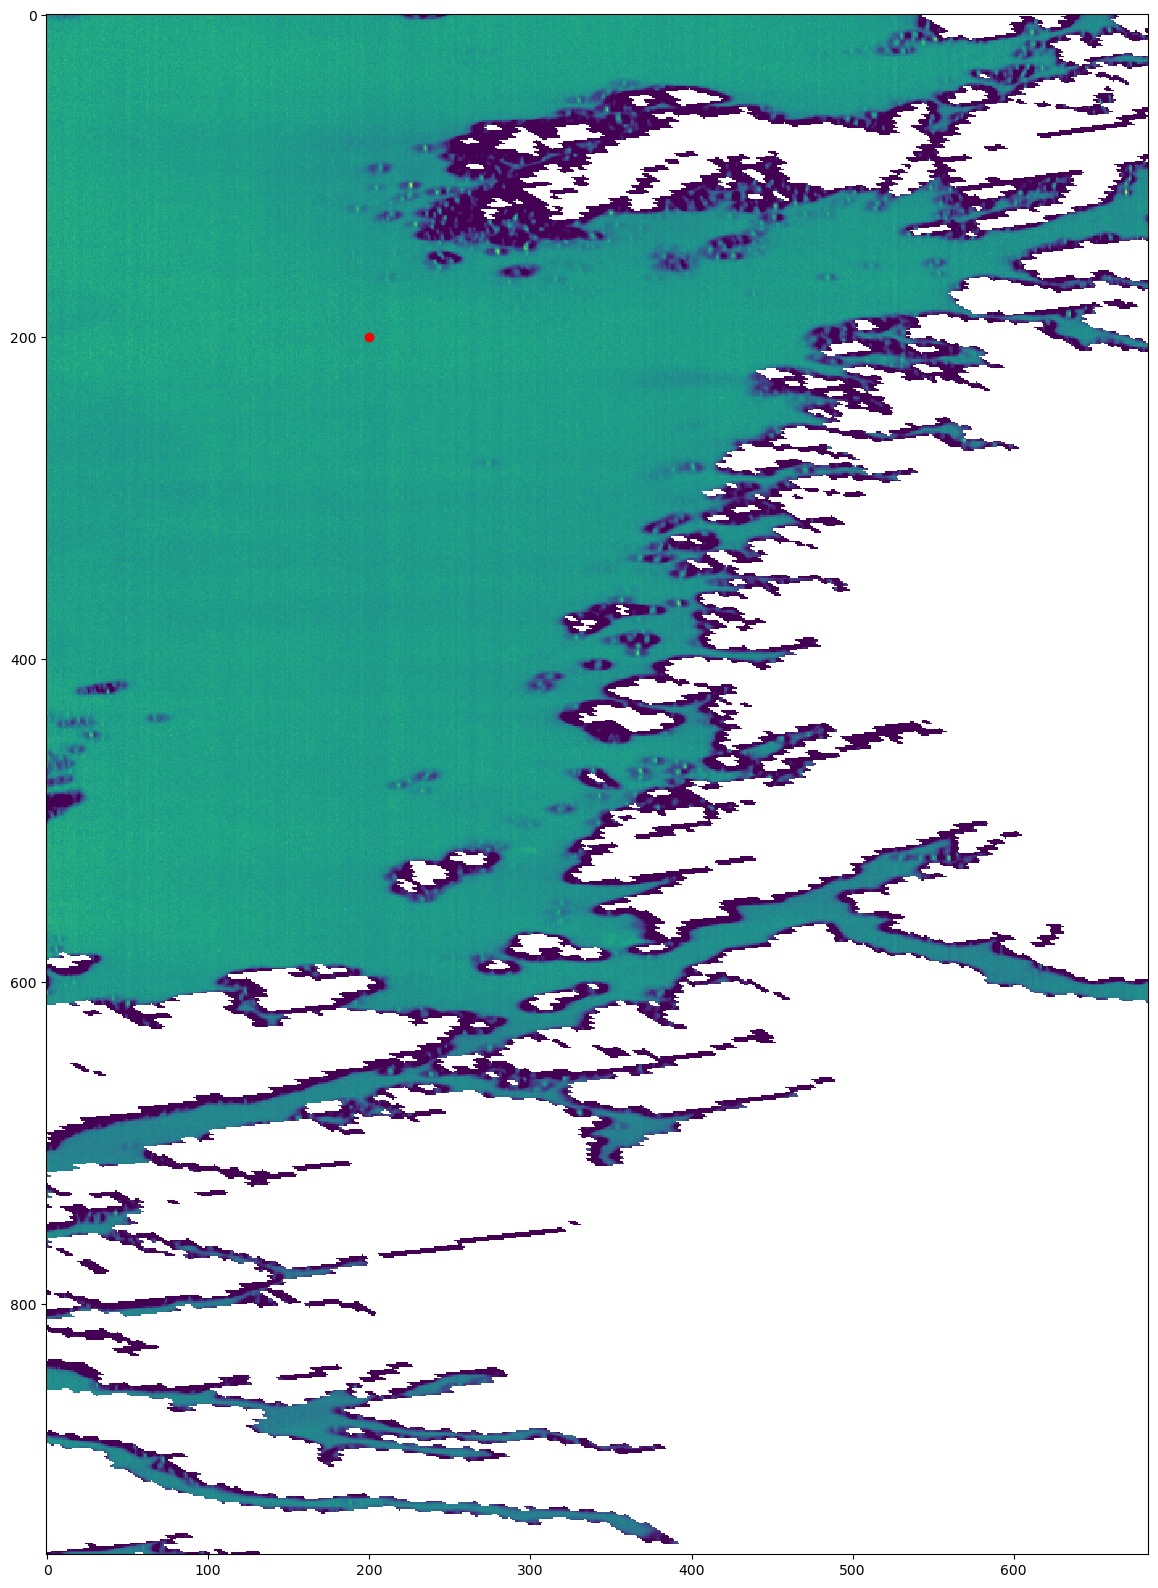

In [14]:
# Chlorophyll estimates
chlor = scene[band_549nm_name] / scene[band_663nm_name]
chlor = chlor.to_numpy()

chlor = np.ma.masked_array(chlor, land_mask, fill_value=np.nan)

chlor = chlor - 0.5*chlor.compressed().max()
#chlor = chlor - 0.88*chlor.compressed().max()
chlor[chlor < 0] = 0

chlor = chlor[:,::-1]

plt.figure(figsize=(20,20))
plt.imshow(chlor, interpolation='none')
plt.plot(200,200,'ro') 

# Concentration in units mg m-3

In [13]:
chlor[200,200]

1.8822274

In [11]:
coords = scene[band_549nm_name].coords

scene['chlor_a'] = xr.DataArray(chlor, coords=coords)
scene['chlor_a'].attrs['area'] = scene[band_549nm_name].attrs['area']
scene['chlor_a'].attrs['start_time'] = scene[band_549nm_name].attrs['start_time']
scene['chlor_a'].attrs['end_time'] = scene[band_549nm_name].attrs['end_time']
scene['chlor_a'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['chlor_a'].attrs['ancillary_variables'] = []

scene['land_mask'] = xr.DataArray(land_mask, coords=coords)
scene['land_mask'].attrs['area'] = scene[band_549nm_name].attrs['area']
scene['land_mask'].attrs['start_time'] = scene[band_549nm_name].attrs['start_time']
scene['land_mask'].attrs['end_time'] = scene[band_549nm_name].attrs['end_time']
scene['land_mask'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['land_mask'].attrs['ancillary_variables'] = []

scene['cloud_mask'] = xr.DataArray(cloud_mask, coords=coords)
scene['cloud_mask'].attrs['area'] = scene[band_549nm_name].attrs['area']
scene['cloud_mask'].attrs['start_time'] = scene[band_549nm_name].attrs['start_time']
scene['cloud_mask'].attrs['end_time'] = scene[band_549nm_name].attrs['end_time']
scene['cloud_mask'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['cloud_mask'].attrs['ancillary_variables'] = []

scene.save_datasets(writer='cf', 
                    datasets=['chlor_a', 'land_mask', 'cloud_mask'], 
                    filename = './datasets_out/' + l1a_file_prefix+'-chlor_a' + '.nc')

/home/cameron/miniforge3/lib/python3.10/site-packages/satpy/writers/cf_writer.py:274: UserWarning: dtype bool not compatible with CF-1.7.
  grouped_datasets, header_attrs = collect_cf_datasets(list_dataarrays=datasets,  # list of xr.DataArray


[None]

In [18]:
datasets = scene.available_dataset_names()
scene.load(datasets)
ds = scene.to_xarray()
da = ds.to_stacked_array('band', sample_dims=['lines','samples'])
da.to_numpy().shape

/home/cameron/miniforge3/lib/python3.10/site-packages/satpy/_scene_converters.py:95: UserWarning: dtype bool not compatible with CF-1.7.
  grouped_datasets, header_attrs = collect_cf_datasets(list_dataarrays=list_dataarrays,


ValueError: Variables in the dataset must contain all ``sample_dims`` (['lines', 'samples']) but 'band_0' misses ['lines', 'samples']